In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
from os import listdir
from os import getcwd
from xml.etree import ElementTree
from mrcnn.utils import Dataset

In [11]:
#load and parse file
filename = 'cam_image1.xml'
tree = ElementTree.parse(filename)

In [12]:
root = tree.getroot()

In [13]:
#get bounding box element
for box in root.findall('.//bndbox'):
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    coor = [xmin, ymin, xmax, ymax]

In [14]:
width = int(root.find('.//width').text)
height = int(root.find('.//height').text)

In [15]:
a = list()

In [16]:
def extract_boxes(filename):
    #load file
    tree = ElementTree.parse(filename)
    #get root
    root = tree.getroot()
    #make a list to store boxes
    boxes = []
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coord = [xmin, ymin, xmax, ymax]
        boxes.append(coord)
    width = int(root.find('.//width').text)
    height = int(root.find('.//height').text)
    return boxes, width, height

In [17]:
boxes, w, h = extract_boxes(filename)
print(boxes, w, h)

[[173, 24, 260, 137], [165, 135, 253, 251], [255, 96, 337, 208]] 480 270


In [18]:
"jeremy.jpg".split('.')[0]

'jeremy'

In [19]:
class CardDataset(Dataset):
    #load databse
    def load_dataset(self, dataset_dir, is_train = True):
        #define one class
        self.add_class("dataset", 1, "Playing Card")
        #define data locations
        #images_dir = dataset_dir + '/train/'
        #annot_dir = dataset_dir + '/train/'
        #folder = is_train ? '/train/' : '/test/'
        folder = '/train/' if is_train else '/test/'
        t_dir = dataset_dir + folder #.../train
        img_dir = t_dir + '/images/'
        ann_dir = t_dir + '/annotations/'
        for filename in listdir(img_dir):
            #extract img id by removing the ".jpg"
            image_id = filename.split('.')[0]
            img_path = img_dir + filename
            ann_path = ann_dir + image_id + '.xml'
            #add to dataset
            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)
     
    #extract bounding boxes from annotation file
    def extract_boxes(self, filename):
    #load file
        tree = ElementTree.parse(filename)
        #get root
        root = tree.getroot()
        #make a list to store boxes
        boxes = []
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coord = [xmin, ymin, xmax, ymax]
            boxes.append(coord)
        width = int(root.find('.//width').text)
        height = int(root.find('.//height').text)
        return boxes, width, height
        
    #load load  mask
    def load_mask(self, image_id):
        #get image information
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype = 'uint8')
        
        #create mask
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3] #ymin, ymax
            col_s, col_e = box[0], box[2] #xmin, xmax
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Playing Card'))
        return masks, np.asarray(class_ids, dtype = 'int32')
    
    #load image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info[path]

train_set = CardDataset()
train_set.load_dataset('DATASET')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))


test_set = CardDataset()
test_set.load_dataset('DATASET', is_train = False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 296
Test: 67


(270, 480, 3)


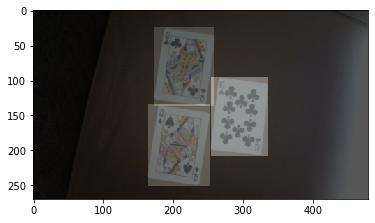

In [20]:
im_id = 'cam_image13'
image = train_set.load_image(0)
print(image.shape)
mask, class_ids = train_set.load_mask(0)
plt.imshow(image)
for j in range(mask.shape[2]):
    plt.imshow(mask[:,:,j], cmap = 'gray', alpha = 0.3)
plt.show()

## Train the model

In [11]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

In [12]:
class CardConfig(Config):
    NAME = 'Card_cfg'
    NUM_CLASSES = 1 + 1 #non-card + Playing Card
    STEPS_PER_EPOCH = 8

config = CardConfig()    

In [13]:
model = MaskRCNN(mode = 'training', model_dir='./', config = config)

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
#load weights (mscoco)
mscoco = 'mask_rcnn_coco.h5'
model.load_weights(mscoco, by_name = True, exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [17]:
%%time
#Training (this might take a while)
model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./card_cfg20190715T2241\mask_rcnn_card_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

C:\Users\JeremyTandjung\Anaconda3\envs\python-cvcourse\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
296/296 [==============================] - 14355s 48s/step - loss: 0.6728 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.2540 - val_loss: 0.5852 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.2416 - val_mrcnn_class_loss: 0.0233 - val_mrcnn_bbox_loss: 0.1325 - val_mrcnn_mask_loss: 0.1776
Epoch 2/5
296/296 [==============================] - 14169s 48s/step - loss: 0.3446 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1470 - val_loss: 0.4656 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.1541 - val_mrcnn_class_loss: 0.0308 - val_mrcnn_bbox_loss: 0.1152 - val_mrcnn_mask_loss: 0.1606
Epoch 3/5
296/296 [==============================] - 14153s 48s/step - loss: 0.2788 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1304 - val_loss: 0.5295 - val_rpn_c

## Evaluate Model

In [1]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from numpy import expand_dims
from numpy import mean

Using TensorFlow backend.


In [2]:
class PredictionConfig(Config):
    NAME = "card_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

NameError: name 'Config' is not defined

In [17]:
def evaluate_model(dataset, model, cfg):
    APs = []
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [16]:
cfg = PredictionConfig()

In [17]:
model = MaskRCNN(mode = 'inference', model_dir = './', config = cfg)
model.load_weights('mask_rcnn_card_cfg_0005.h5', by_name = True)

Instructions for updating:
Use tf.cast instead.


In [35]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.985
Test mAP: 0.944


## Put bounding boxes on new image

In [20]:
from matplotlib.patches import Rectangle

In [24]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()


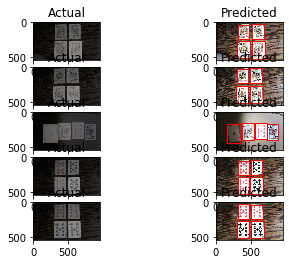

In [25]:
plot_actual_vs_predicted(test_set, model, cfg)

## Live Capture

In [3]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from numpy import expand_dims
from numpy import mean

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
class PredictionConfig(Config):
    NAME = "card_cfg"
    # number of classes (background + card)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [5]:
cfg = PredictionConfig()

In [6]:
model = MaskRCNN(mode = 'inference', model_dir = './', config = cfg)
model.load_weights('mask_rcnn_card_cfg_0005.h5', by_name = True)

In [7]:
def locate_card(image):
    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose = 0)[0]
    for box in yhat['rois']:
        y1, x1, y2, x2 = box
        w, h = x2-x1, y2-y1
        cv2.rectangle(image, (x1,y1), (x2,y2), (255,255,255), 5)
    return image

In [7]:
'''
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read(0)
    
    frame = locate_card(frame)
    
    cv2.imshow('Card Detection', frame)
    
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()
'''

"\ncap = cv2.VideoCapture(0)\n\nwhile True:\n    ret, frame = cap.read(0)\n    \n    frame = locate_card(frame)\n    \n    cv2.imshow('Card Detection', frame)\n    \n    c = cv2.waitKey(1)\n    if c == 27:\n        break\n\ncap.release()\ncv2.destroyAllWindows()\n"

In [8]:
test = cv2.imread('file-3.jpeg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

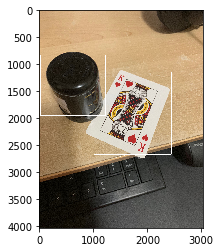

In [9]:
plt.imshow(locate_card(test))

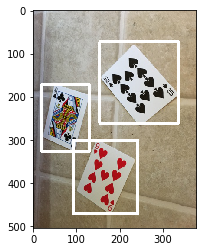

In [10]:
test = cv2.imread('IMG_2571.JPG')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(locate_card(test))

In [11]:
def draw_bounding_box(filename):
    test = cv2.imread(filename)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    plt.imshow(locate_card(test))